In [1]:
# This file will be used for testing purposes

In [2]:
# In cwd there is a directory called "single_image_testing", put the image you want to test in that directory

In [3]:
import os
import re
import itertools

In [4]:
cwd = os.getcwd()
test_dir_path = os.path.join(cwd, "single_image_testing")

In [5]:
filename=os.listdir(test_dir_path)[0]
file_path = os.path.join(test_dir_path, filename)
print(file_path)

C:\Users\METE\Desktop\cekcoz_main\single_image_testing\A001259.png


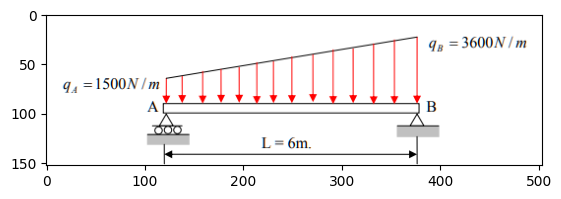

In [6]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
img = cv.imread(file_path)
plt.imshow(img)
plt.show()

In [7]:
def detect_fn(image, detection_model):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [8]:
def show_object_detection_results(image_np, detections, category_index, label_id_offset=1):
    """
    Displays object detection results labeled on input image
    :param image_np: numpy formatted image
    :param detections: detection results
    :param category_index: detection class index
    :param label_id_offset: class index - label name dict
    :return: None (shows detection result)
    """
    image_np_with_detections = image_np.copy()
    from object_detection.utils import visualization_utils as viz_utils
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.3,
        agnostic_mode=False,
        line_thickness=1,
        skip_scores=True,
        skip_labels = True)
    cv.imshow("image with detections", image_np_with_detections)
    cv.waitKey()

In [9]:
def process_data(box, detection_class, score, label_id_offset=1):
    """
    Taking TensforFlow formatted information and formats them for easy usage
    :param box: obj det bboxes
    :param detection_class: class of the detected object
    :param score: detection score
    :param label_id_offset: Highly likely equals to 1 ( for offset purpose)
    :return: returns the list including information with some logic
    """
    return list([box[0], box[1], box[2], box[3], detection_class + label_id_offset, score])

In [10]:
def remove_ambiguous_detections(threshold, data_list, category_index, img_width, img_height):
    """
    Will take object detection results and remove doubtfull detections
    :param threshold: confidence score, detections has lower than this score will be removed
    :param data_list: list containing object detection results
    :param category_index: index of the classes
    :param img_width: x-pixel value of the current image
    :param img_height: y-pixel value of the current image
    :return: returns list which has cleared all ambigous detections
    """
    new_data_list = []
    for whole_values in data_list:
        dummy_list = []
        if whole_values[5] > threshold:
            label_name = (category_index.get(int(whole_values[4]))).get("name")
            ymin = int(whole_values[0] * img_height)
            xmin = int(whole_values[1] * img_width)
            ymax = int(whole_values[2] * img_height)
            xmax = int(whole_values[3] * img_width)
            dummy_list.append(ymin)
            dummy_list.append(xmin)
            dummy_list.append(ymax)
            dummy_list.append(xmax)
            dummy_list.append(label_name)
            new_data_list.append(dummy_list)
    return new_data_list

In [11]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import time

def read_text_on_image(path):
    """
    Reads text on image
    :param path: input image path
    :return: ocr text
    """

    subscription_key = "d9db8bd3bed7440a86b510dca41abdc6"
    endpoint = "https://cekcozocr.cognitiveservices.azure.com/"

    computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

    read_image_path = path
    # Open the image
    read_image = open(read_image_path, "rb")

    # Call API with image and raw response (allows you to get the operation location)
    read_response = computervision_client.read_in_stream(read_image, raw=True)
    # Get the operation location (URL with ID as last appendage)
    read_operation_location = read_response.headers["Operation-Location"]
    # Take the ID off and use to get results
    operation_id = read_operation_location.split("/")[-1]

    # Call the "GET" API and wait for the retrieval of the results
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status.lower() not in ['notstarted', 'running']:
            break
        print('Waiting for result...')
        time.sleep(3)

    reading_results = []
    # Print results, line by line
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                dummy_list = [line.text, line.bounding_box]
                reading_results.append(dummy_list)
    return reading_results

In [12]:
def clean_ocr_results(ocr_results):
    """
    Removing bad reading characters
    :param ocr_results: initial reading results
    :return: cleansed results
    """
    # A list of meaningless readings. You can extend this list as required
    meaningless_readings = ["-"]

    # Filter out results with meaningless readings
    cleaned_results = [result for result in ocr_results if result[0] not in meaningless_readings]

    return cleaned_results

In [13]:
def match_spacings(spacing_bbox, readings):
    """
    Takes detection results classified as "spacing" and matching them with corresponding reading
    :param spacing_bbox: bbox of spacing instance
    :param readings: ocr readings
    :return: list [[ocr reading], [reading bbox], [obj det bbox]]
    """
    final_results = []
    for bbox in spacing_bbox:
        threshold = adjust_threshold(bbox)
        filtered_ocr_results = filter_results_by_distance(bbox, readings, threshold)
        if filtered_ocr_results:
            for item in filtered_ocr_results:
                result = [[item[0]], item[1], bbox]
                final_results.append(result)
    return final_results

In [14]:
def ocr_secondary_filter_distance(matching_results):
    """
    Filters readings to remove absurd characters
    :param matching_results: first filter results
    :return: input with bad readings removed
    """
    pattern = r"(\d+([.]\d+)?|(\d+\s*/\s*\d+))\s*(m|meters?)"
    for item in matching_results:
        reading = item[0][0]
        match = re.search(pattern, reading)
        if match:
            extracted_value = match.group()
            item[0][0] = extracted_value  # Update the original reading with the extracted value
    return matching_results

In [15]:
def extract_value_unit(sec_filtered_results):
    """
    Extracts precise value and units from ocr text
    :param sec_filtered_results: text results after two times filtering
    :return: replacing input's text part with a list containing unit and value
    """
    # regex pattern to match value and unit (supports meter, m, feet, ft, inch)
    pattern = r'(\d+)\s*(meters?|ft|feet|inch(?:es)?|m)'
    for element in sec_filtered_results:
        match = re.search(pattern, element[0][0], re.IGNORECASE)
        if match:
            value, unit = match.groups()
            element[0] = [int(value), unit]
    return sec_filtered_results

In [16]:
def sorting_key(entry):
    """
    Sorts dimensions according to avg_x and then by avg_y in reverse order
    :param entry: List containing spacing info
    :return: tuple used for sorting
    """
    # Extract object detection bounding box
    y1, x1, y2, x2 = entry[2]
    avg_x = (x1 + x2) / 2
    avg_y = (y1 + y2) / 2
    # Return a tuple where avg_x is the primary key and -avg_y is the secondary key
    return (avg_x, -avg_y)

In [17]:
def dimension_direction(sorted_spacings, img):
    """
    Decides direction of the dimension using pixel values
    :param sorted_spacings: list of spacings
    :param img: input image
    :return: adds direction to the input list and returns it back
    """
    sorted_spacing_with_direction = []
    for spacing_info in sorted_spacings:
        y1, x1, y2, x2 = spacing_info[2]
        roi = img[y1:y2, x1:x2]
        gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)

        # Threshold the image
        _, thresh = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)  # Adjust the threshold value as needed

        # Sum along x and y axes
        sum_x = np.sum(thresh, axis=0)
        sum_y = np.sum(thresh, axis=1)

        # Check where the predominant sum is
        x_peak = np.max(sum_x)
        y_peak = np.max(sum_y)

        # Decide the direction based on the peaks
        if x_peak > 1.5 * y_peak:  # Adjust the factor as needed
            direction = "vertical"
        elif y_peak > 1.5 * x_peak:
            direction = "horizontal"
        else:
            direction = "angled"

        spacing_info.append(direction)

        # Append the updated spacing_info to the global list
        sorted_spacing_with_direction.append(spacing_info)

    return sorted_spacing_with_direction

In [18]:
def initialize_parameters(sorted_spacings_with_directions):
    """
    Initializes base classes for question
    :param sorted_spacings_with_directions: list containing spacing information
    :return: created instances of nodes and spacings
    """
    spacing_instances = []
    node_instances = []
    shape_x_start = 0
    shape_y_start = 0
    for spacing_info in sorted_spacings_with_directions:
        if not spacing_instances:
            if spacing_info[3] == "horizontal":
                y1, x1, y2, x2 = spacing_info[2]
                distance = spacing_info[0][0]
                unit = spacing_info[0][1]
                obj_det_bbox = spacing_info[2]
                text_bbox = spacing_info[1]
                bbox_x = x1
                bbox_y = int((y1 + y2) / 2)
                node_1 = Node(bbox_x, bbox_y, shape_x_start, shape_y_start)
                node_instances.append(node_1)
                bbox_x = x2
                bbox_y = int((y1 + y2) / 2)
                node_2 = Node(bbox_x, bbox_y, shape_x_start + int(distance), shape_y_start)
                node_instances.append(node_2)
                spacing = Dimension(node_1, node_2, distance, unit, obj_det_bbox, text_bbox)
                spacing_instances.append(spacing)
            elif spacing_info[3] == "vertical":
                y1, x1, y2, x2 = spacing_info[2]
                distance = spacing_info[0][0]
                unit = spacing_info[0][1]
                obj_det_bbox = spacing_info[2]
                text_bbox = spacing_info[1]
                bbox_x = int(x1 + x2) / 2
                bbox_y = y1
                node_1 = Node(bbox_x, bbox_y, shape_x_start, shape_y_start)
                node_instances.append(node_1)
                bbox_x = int(x1 + x2) / 2
                bbox_y = y2
                node_2 = Node(bbox_x, bbox_y, shape_x_start, shape_y_start + int(distance))
                node_instances.append(node_2)
                spacing = Dimension(node_1, node_2, distance, unit, obj_det_bbox, text_bbox)
                spacing_instances.append(spacing)
            else:
                # code the nodes for angled dimensioning
                pass
        else:
            if spacing_info[3] == "horizontal":
                y1, x1, y2, x2 = spacing_info[2]
                distance = spacing_info[0][0]
                unit = spacing_info[0][1]
                obj_det_bbox = spacing_info[2]
                text_bbox = spacing_info[1]
                bbox_x = x1
                bbox_y = int(y1 + y2) / 2
                node_1 = Node(bbox_x=bbox_x, bbox_y=bbox_y)
                bbox_x = x2
                bbox_y = int(y1 + y2) / 2
                node_2 = Node(bbox_x=bbox_x, bbox_y=bbox_y)
                # psc_node = previous spacing closest node
                # cc_node = current closest node
                psc_node, cc_node = find_closest_node_of_previous_spacing(spacing_instances[-1], node_1, node_2)
                if cc_node == node_1:
                    node_2.shape_x = psc_node.shape_x + distance
                    node_2.shape_y = psc_node.shape_y
                    node_instances.append(node_2)
                    spacing = Dimension(psc_node, node_2, distance, unit, obj_det_bbox, text_bbox)
                    spacing_instances.append(spacing)
                else:
                    node_1.shape_x = psc_node.shape_x - distance
                    node_1.shape_y = psc_node.shape_y
                    node_instances.append(node_1)
                    spacing = Dimension(node_1, psc_node, distance, unit, obj_det_bbox, text_bbox)
                    spacing_instances.append(spacing)
            elif spacing_info[3] == "vertical":
                y1, x1, y2, x2 = spacing_info[2]
                distance = spacing_info[0][0]
                unit = spacing_info[0][1]
                obj_det_bbox = spacing_info[2]
                text_bbox = spacing_info[1]
                bbox_x = int(x1 + x2) / 2
                bbox_y = y1
                node_1 = Node(bbox_x=bbox_x, bbox_y=bbox_y)
                bbox_x = int(x1 + x2) / 2
                bbox_y = y2
                node_2 = Node(bbox_x=bbox_x, bbox_y=bbox_y)
                # psc_node = previous spacing closest node
                # cc_node = current closest node
                psc_node, cc_node = find_closest_node_of_previous_spacing(spacing_instances[-1], node_1, node_2)
                if cc_node == node_1:
                    node_2.shape_x = psc_node.shape_x
                    node_2.shape_y = psc_node.shape_y - distance
                    node_instances.append(node_2)
                    spacing = Dimension(psc_node, node_2, distance, unit, obj_det_bbox, text_bbox)
                    spacing_instances.append(spacing)
                else:
                    node_1.shape_x = psc_node.shape_x
                    node_1.shape_y = psc_node.shape_y + distance
                    node_instances.append(node_1)
                    spacing = Dimension(node_1, psc_node, distance, unit, obj_det_bbox, text_bbox)
                    spacing_instances.append(spacing)
            else:
                pass
    return spacing_instances, node_instances

In [19]:
def adjust_threshold(bbox):
    """
    Dynamically adjusts threshold for "filter_results_by_distance" function
    Logic is finding smaller axis (x or y) and adds some pixel to that axis length
    :param bbox: bbox of the object
    :return: calculated threshold value
    """
    if bbox[3]-bbox[1] > bbox[2]-bbox[0]:
        return bbox[2]-bbox[0]+10
    else:
        return bbox[3]-bbox[1] + 10

In [20]:
def compute_center_ocr(bbox):
    """
    Computes center point of ocr reading
    :param bbox: bbox in format [x1, y1, x2, y2, x3, y3, x4, y4] (starts from top left order is clockwise)
    :return: avg_x, avg_y
    """
    x1, y1, x2, y2, x3, y3, x4, y4 = bbox
    center_x = (x1 + x3) / 2
    center_y = (y1 + y3) / 2
    return center_x, center_y

In [21]:
def compute_center_obj(bbox):
    """
    Computes center point of bbox
    :param bbox: bbox in format [y1,x1,y2,x2]
    :return: avg_x, avg_y
    """
    y1, x1, y2, x2 = bbox
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    return center_x, center_y

In [22]:
def euclidean_distance(center1, center2):
    """
    Calculates distance between [x1,y1] and [x2,y2]
    :param center1: center coordinates of first point
    :param center2: center coordinates of second point
    :return: distance
    """
    return ((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)**0.5

In [23]:
def is_valid_reading_distance(reading):
    """
    Checks if reading fits pattern considering distance units
    (only check if it contains units, secondary regex will be done)
    :param reading: reading results obtained from ocr
    :return: returns reading if it fits pattern
    """
    pattern = r"(\d+\s*(?:meters?|ft|feet|inch(?:es)?|m))"
    return re.search(pattern, reading)

In [24]:
def filter_results_by_distance(obj_detection_bbox, ocr_results, threshold):
    """
    Narrowing down possible matches for obj's and ocr's by discarding values farther away than threshold
    :param obj_detection_bbox: bbox of object
    :param ocr_results: bbox of ocr reading
    :param threshold: limit value, after calculating center of obj bbox and ocr reading bbox,
    if calculated value is more than threshold, that value will be discarded
    :return: returns readings within threshold value
    """
    filtered_results = []
    obj_center = compute_center_obj(obj_detection_bbox)

    for result in ocr_results:
        reading, ocr_bbox = result
        if not is_valid_reading_distance(reading):  # check if the reading is valid
            continue
        ocr_center = compute_center_ocr(ocr_bbox)
        distance = euclidean_distance(obj_center, ocr_center)
        if distance < threshold:
            filtered_results.append(result)

    return filtered_results

In [50]:

class Dimension:
    def __init__(self, node_1=None, node_2=None, value=None, unit=None, obj_det_bbox=None, text_bbox=None):
        self.node_1 = node_1
        self.node_2 = node_2
        self.value = value
        self.unit = unit
        self.obj_det_bbox = obj_det_bbox
        self.text_bbox = text_bbox

    def __repr__(self):
        return (f"Dimension(node_1={self.node_1}, node_2={self.node_2}, value={self.value}, "
                f"unit={self.unit}, obj_det_bbox={self.obj_det_bbox}, text_bbox={self.text_bbox})")


class Node:
    def __init__(self, bbox_x=None, bbox_y=None, shape_x=None, shape_y=None, name=None):
        self.bbox_x = bbox_x
        self.bbox_y = bbox_y
        self.shape_x = shape_x
        self.shape_y = shape_y
        self.name = name

    def __eq__(self, other):
        if isinstance(other, Node):
            return (self.bbox_x == other.bbox_x and self.bbox_y == other.bbox_y
                    and self.shape_x == other.shape_x and self.shape_y == other.shape_y
                    and self.name == other.name)
        return False

    def __repr__(self):
        return f"Node(name={self.name}, bbox_x={self.bbox_x}, bbox_y={self.bbox_y}, shape_x={self.shape_x}," \
               f" shape_y={self.shape_y})"


class FixSupport:
    def __init__(self, node=None, fx=0, fy=0, moment=0):
        self.node = node
        self.fx = fx
        self.fy = fy
        self.moment = moment

    def __repr__(self):
        return f"FixSupport(node={self.node}, Fx={self.fx}, Fy={self.fy}, Moment={self.moment})"


class PinSupport:
    def __init__(self, node=None, fx=0, fy=0):
        self.fx = fx
        self.fy = fy
        self.node = node

    def __repr__(self):
        return f"PinSupport(node={self.node}, Fx={self.fx}, Fy={self.fy})"


class RollerSupport:
    def __init__(self, node=None, fy=0):
        self.fy = fy
        self.node = node

    def __repr__(self):
        return f"RollerSupport(node={self.node}, Fy={self.fy})"


class Frame:
    def __init__(self, node1=None, node2=None, obj_det_bbox=None, direction=None):
        self.node_1 = node1
        self.node_2 = node2
        self.obj_det_bbox = obj_det_bbox
        self.direction = direction

    def __repr__(self):
        return f"Frame(node_1={repr(self.node_1)}, node_2={repr(self.node_2)}, obj_det_bbox={self.obj_det_bbox}," \
               f" direction={self.direction})"


class PointLoad:
    def __init__(self, node=None, direction=None, value=None, unit=None, text_bbox=None, obj_det_bbox=None):
        self.node = node
        self.direction = direction
        self.value = value
        self.unit = unit
        self.text_bbox = text_bbox
        self.obj_det_bbox = obj_det_bbox

    def __repr__(self):
        return f"PointLoad(node={self.node}, direction={self.direction}, value={self.value}, unit={self.unit}," \
               f" text_bbox = {self.text_bbox}, obj_det_bbox = {self.obj_det_bbox})"

class DistributedLoad:
    def __init__(self, node1=None, node2=None,obj_det_bbox = None, direction=None, value=None, unit=None):
        self.node1 = node1
        self.node2 = node2
        self.obj_det_bbox = obj_det_bbox
        self.direction = direction
        self.value = value
        self.unit = unit

    def __repr__(self):
        return f"DistributedLoad(node1={self.node1}, node2={self.node2}, obj_det_bbox={self.obj_det_bbox}, direction={self.direction}, value={self.value}, unit={self.unit})"

class TriangularDistributedLoad:
    def __init__(self, node1=None, node2=None,obj_det_bbox = None, direction=None, value1=None, value2=None, unit=None):
        self.node1 = node1
        self.node2 = node2
        self.obj_det_bbox = obj_det_bbox
        self.direction = direction
        self.value1 = value1
        self.value2 = value2
        self.unit = unit

    def __repr__(self):
        return f"TriangularDistributedLoad(node1={self.node1}, node2={self.node2}, obj_det_bbox={self.obj_det_bbox}, direction={self.direction}, value1={self.value1}, value2={self.value2}, unit={self.unit})"

In [51]:
def correct_shapes(node_list):
    """
    Nodes with negative values are corrected in this function
    :param node_list: list of nodes
    :return: corrected list of nodes
    """
    # Find the minimum shape_x and shape_y values
    min_shape_x = min(node.shape_x for node in node_list)
    min_shape_y = min(node.shape_y for node in node_list)

    # Calculate the offsets required to make the smallest shape values zero
    offset_x = abs(min_shape_x) if min_shape_x < 0 else 0
    offset_y = abs(min_shape_y) if min_shape_y < 0 else 0

    # Apply the offsets to all node instances
    for node in node_list:
        node.shape_x += offset_x
        node.shape_y += offset_y

    return node_list

In [52]:
def find_and_append_missing_nodes(node_instances):
    """
    Creates missing nodes according to every definable point
    :param node_instances: Raw (negative value corrected) node points
    :return: New list (if any new node created in the process)
    """
    # Extract unique shape_x and shape_y values
    unique_shape_x = {node.shape_x for node in node_instances}
    unique_shape_y = {node.shape_y for node in node_instances}

    # Generate all possible combinations based on the unique values
    shape_combinations = set(itertools.product(unique_shape_x, unique_shape_y))

    # Identify existing combinations from node_instances
    existing_shapes = {(node.shape_x, node.shape_y) for node in node_instances}

    # Identify missing combinations
    missing_shapes = shape_combinations - existing_shapes

    # For each missing shape combination, create and append a new node to node_instances
    for shape_x, shape_y in missing_shapes:
        node_for_shape_x = next((node for node in node_instances if node.shape_x == shape_x), None)
        node_for_shape_y = next((node for node in node_instances if node.shape_y == shape_y), None)

        bbox_x = node_for_shape_x.bbox_x if node_for_shape_x else None
        bbox_y = node_for_shape_y.bbox_y if node_for_shape_y else None

        missing_node = Node(bbox_x=bbox_x, bbox_y=bbox_y, shape_x=shape_x, shape_y=shape_y)
        node_instances.append(missing_node)

    return node_instances

In [53]:
def append_names_to_nodes(node_instances, ocr_results, distance_threshold=100):
    """
    Appends name to the nodes, node names are generally symbolized with one character (A,B,C, etc.)
    Closest reading mathching to this pattern is appended if reading is in the threshold value
    :param node_instances: node list
    :param ocr_results: ocr text
    :param distance_threshold: pixel value
    :return: name appended node list
    """
    pattern = r'^[A-Za-z]$'
    for text, bbox in ocr_results:
        if re.match(pattern, text):  # Check if the text is a single letter (either uppercase or lowercase)
            center_x = sum(bbox[i] for i in [0, 2, 4, 6]) / 4
            center_y = sum(bbox[i] for i in [1, 3, 5, 7]) / 4

            distances = [(node, euclidean_distance([center_x, center_y], [node.bbox_x, node.bbox_y]))
                         for node in node_instances]
            closest_node, min_distance = min(distances, key=lambda x: x[1])

            if min_distance <= distance_threshold:
                closest_node.name = text
    return None

In [54]:
def create_support_instances(support_bbox, node_instances):
    """
    Creating support instances according to the obj det support instances
    :param support_bbox: bbox coordinates and class information of supports
    :param node_instances: node information
    :return: created support classes which also has their own nodes appended
    """
    fix_support_instances = []
    pin_support_instances = []
    roller_support_instances = []
    for bbox in support_bbox:
        center_x = (bbox[1] + bbox[3]) / 2
        center_y = (bbox[0] + bbox[2]) / 2
        closest_node = min(node_instances, key=lambda node: euclidean_distance([center_x, center_y], [node.bbox_x, node.bbox_y]))
        if bbox[-1] == 'fix_support':
            fix_support_instances.append(FixSupport(node=closest_node))
        elif bbox[-1] == 'pin_support':
            pin_support_instances.append(PinSupport(node=closest_node))
        elif bbox[-1] == 'roller_support':
            roller_support_instances.append(RollerSupport(node=closest_node))
        else:
            pass
    return fix_support_instances, pin_support_instances, roller_support_instances

In [55]:
def find_frame_direction(frame_boxes, img):
    """
    Finds and appends direction of the frame
    :param frame_boxes: bbox info of frame
    :param img: input image
    :return: direction appended bbox list
    """
    for frame_info in frame_boxes:
        y1,x1,y2,x2 = frame_info[:4]
        roi = img[y1:y2, x1:x2]
        gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
         # Threshold the image
        _, thresh = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)  # Adjust the threshold value as needed

        # Sum along x and y axes
        sum_x = np.sum(thresh, axis=0)
        sum_y = np.sum(thresh, axis=1)

        # Check where the predominant sum is
        x_peak = np.max(sum_x)
        y_peak = np.max(sum_y)

        # Decide the direction based on the peaks
        if x_peak > 1.5 * y_peak:  # Adjust the factor as needed
            direction = "vertical"
        elif y_peak > 1.5 * x_peak:
            direction = "horizontal"
        else:
            direction = "angled"
        frame_info.append(direction)
    return frame_boxes

In [56]:
def initialize_frames(frame_boxes, node_instances):
    """
    Creates instances of frames
    :param frame_boxes: bbox list of frames
    :param node_instances: list of nodes
    :return: list of frame instances
    """
    frame_instances = []
    for box in frame_boxes:
        if box[5] == "horizontal":
            x1 = box[1]
            x2 = box[3]
            y = int((box[0] + box[2]) / 2)

            # Get the closest node to x1 and x2
            c_node1 = find_closest_node(x1, y, node_instances)
            c_node2 = find_closest_node(x2, y, node_instances)

            frame_instance = Frame(node1=c_node1, node2=c_node2)
            frame_instances.append(frame_instance)
        elif box[5] == "vertical":
            y1 = box[0]
            y2 = box[2]
            x = int((box[1] + box[3]) / 2)
            # Get the closest node to x1 and x2
            c_node1 = find_closest_node(x, y1, node_instances)
            c_node2 = find_closest_node(x, y2, node_instances)

            frame_instance = Frame(node1=c_node1, node2=c_node2)
            frame_instances.append(frame_instance)
        else:
            # Need to fill this later
            pass
    return frame_instances

In [57]:
def find_closest_node(x, y, nodes):
    """
    Self explained
    :param x: x coordinate
    :param y: y coordinate
    :param nodes: node instances
    :return:
    """
    def node_distance(node):
        """
        Distance between coordinates and nodes
        :param node: single node instance
        :return: distance between node bbox center and given x-y coordinates
        """
        return euclidean_distance([x, y], [node.bbox_x, node.bbox_y])
    return min(nodes, key=node_distance)

In [58]:
def divide_frames(frame, node_instances):
    """
    Checks current frame instance and if frame passes through any nodes except the ones it is defined, it divides frame
    :param frame: single frame instances
    :param node_instances: list of nodes
    :return: list of new frames
    """
    # Check if it's a horizontal frame (direction is along x-axis) or vertical (direction is along y-axis)
    is_horizontal = frame.node_1.shape_y == frame.node_2.shape_y

    new_frames = []

    # Extract the node list that lies between the nodes of this frame
    if is_horizontal:
        intermediate_nodes = sorted([node for node in node_instances
                                     if frame.node_1.shape_y == node.shape_y
                                     and frame.node_1.shape_x < node.shape_x < frame.node_2.shape_x],
                                    key=lambda n: n.shape_x)
    else:
        intermediate_nodes = sorted([node for node in node_instances
                                     if frame.node_1.shape_x == node.shape_x
                                     and frame.node_1.shape_y < node.shape_y < frame.node_2.shape_y],
                                    key=lambda n: n.shape_y)

    # If there are no intermediate nodes, just return the original frame
    if not intermediate_nodes:
        return [frame]

    # Create new frames based on intermediate nodes
    start_node = frame.node_1
    for node in intermediate_nodes:
        new_frame = Frame(start_node, node, frame.obj_det_bbox, frame.direction)
        new_frames.append(new_frame)
        start_node = node

    new_frame = Frame(start_node, frame.node_2, frame.obj_det_bbox, frame.direction)
    new_frames.append(new_frame)

    return new_frames

In [59]:
def split_frame_based_on_nodes(frame_instances, node_instances):
    """
    Loops through frame instances to divide them if necessary
    :param frame_instances:  list of frame instances
    :param node_instances: list of node instances
    :return: new frame instances
    """
    new_frames = []
    for frame in frame_instances:
        split_frames = divide_frames(frame, node_instances)
        new_frames.extend(split_frames)
    return new_frames

In [60]:
def create_nominal_frame(node_instances):
    """
    Creates nominal frame if no frame detected
    :param node_instances: list of nodes
    :return: nominal frame
    """
    new_frame_instances = []
    for i in range(len(node_instances)):
        for j in range(i + 1, len(node_instances)):
            frame = Frame(node1=node_instances[i], node2=node_instances[j])
            new_frame_instances.append(frame)
    return new_frame_instances

In [61]:
def  initialize_pl(pl_boxes, node_instances):
    """
    Creates point load instances
    :param pl_boxes: list of pl bbox
    :param node_instances: node list
    :return: instances of pl
    """
    point_load_instances = []
    for box in pl_boxes:
        center_x = (box[1] + box[3]) / 2
        center_y = (box[0] + box[2]) / 2

        try:
            closest_node = min(node_instances,
                               key=lambda node: calculation_utils.euclidean_distance(
                                   [center_x, center_y], [node.bbox_x, node.bbox_y]))

            # For simplicity, I'm not assigning direction, value, and unit.
            # These can be assigned based on further criteria or user input.
            pl_instance = PointLoad(node=closest_node, obj_det_bbox=box[:4])
            point_load_instances.append(pl_instance)
        except IndexError:
            print(f"Error processing box with coordinates: {box}. Skipping to next box.")
    return point_load_instances

In [62]:
def extract_pl_text(pl_boxes, ocr_results, threshold = 200):
    """
    detects texts which are closet than threshold pixel
    :param pl_boxes: list of pl boxes
    :param ocr_results: ocr readins results
    :return: possible readings of pl
    """
    texts_within_range = []

    for pl_box in pl_boxes:
        pl_center_x = (pl_box[1] + pl_box[3]) / 2
        pl_center_y = (pl_box[0] + pl_box[2]) / 2

        for text_entry in ocr_results:
            text, bbox = text_entry[0], text_entry[1]
            center_x = sum(bbox[i] for i in [0, 2, 4, 6]) / 4
            center_y = sum(bbox[i] for i in [1, 3, 5, 7]) / 4

            if calculation_utils.euclidean_distance([pl_center_x, pl_center_y], [center_x, center_y]) <= threshold:
                texts_within_range.append(text_entry)
    return texts_within_range

In [63]:
def extract_precise_text(point_load_instances, possible_pl_text):
    """
    Extracts precise magnitude and value for point loads and assigns related attributes
    :param point_load_instances: list containing pl instances
    :param possible_pl_text: close text to bbox of object detection
    :return: related attributes assigned version of point load instances
    """
    pattern = r"(?:[A-Za-z]*\s*=\s*)?(?P<value>\d+)\s*(?P<unit>kN|k|t)(?P<type>/ft)?"
    for pl in point_load_instances:
        closest_text_entry = None
        min_distance = float('inf')

        for text_entry in possible_pl_text:
            text = text_entry[0]
            bbox = text_entry[1]
            center_x = sum(bbox[i] for i in [0, 2, 4, 6]) / 4
            center_y = sum(bbox[i] for i in [1, 3, 5, 7]) / 4

            match = re.search(pattern, text)
            if match:
                distance = calculation_utils.euclidean_distance([center_x, center_y], [pl.node.bbox_x, pl.node.bbox_y])
                if distance < min_distance:
                    closest_text_entry = text_entry
                    closest_text_bbox = bbox
                    min_distance = distance

        # Assign the closest text entry (if found) to the PointLoad instance
        if closest_text_entry:
            text = closest_text_entry[0]
            match = re.search(pattern, text)
            value = match.group("value")
            unit = match.group("unit")

            pl.value = value
            pl.unit = unit
            pl.text_bbox = closest_text_bbox
    return point_load_instances

In [64]:
def pl_direction(pl_instances, img):
    """
    Detects direction of pl by eroding arrows, eroding it until some threshold, only thickest part (arrowhead) will
    remain, it will show the direction
    :param pl_instances: list of pl instances
    :param img: image
    :return: None (directions appended instances inside)
    """
    for pl in pl_instances:
        y1, x1, y2, x2 = pl.obj_det_bbox
        ocr_bbox = pl.text_bbox

        if pl.text_bbox:
            ry1 = int((ocr_bbox[1] + ocr_bbox[3]) / 2)
            ry2 = int((ocr_bbox[5] + ocr_bbox[7]) / 2)
            rx1 = int((ocr_bbox[0] + ocr_bbox[6]) / 2)
            rx2 = int((ocr_bbox[2] + ocr_bbox[4]) / 2)

            overlap_x1 = max(x1, rx1)
            overlap_y1 = max(y1, ry1)
            overlap_x2 = min(x2, rx2)
            overlap_y2 = min(y2, ry2)

            # If overlap exists, paint it white
            if overlap_x1 < overlap_x2 and overlap_y1 < overlap_y2:
                img[overlap_y1:overlap_y2, overlap_x1:overlap_x2] = 255

        roi = img[y1:y2, x1:x2]
        binary_roi = iterative_erosion(roi, max_iterations=1)

        # Find the non-zero pixels' indices
        y_indices, x_indices = np.where(binary_roi == 255)

        # Calculate the average x and y coordinates
        avg_x = np.mean(x_indices)
        avg_y = np.mean(y_indices)

        # Calculate midpoints of x and y axes
        midpoint_x = binary_roi.shape[1] / 2
        midpoint_y = binary_roi.shape[0] / 2

        # Determine direction
        if avg_y > midpoint_y and abs(avg_x - midpoint_x) < midpoint_x / 2:
            direction = "downward"
        elif avg_y < midpoint_y and abs(avg_x - midpoint_x) < midpoint_x / 2:
            direction = "upward"
        elif avg_x > midpoint_x and abs(avg_y - midpoint_y) < midpoint_y / 2:
            direction = "right"
        elif avg_x < midpoint_x and abs(avg_y - midpoint_y) < midpoint_y / 2:
            direction = "left"
        else:
            direction = "unknown"

        pl.direction = direction

    return None

In [65]:
def extract_precise_text_dl(dl_instances, ocr_text):
    """
    Decides proper text belongs to the distributed load
    :param dl_instances: list keeping instances of distributed load
    :param ocr_text: list keeping ocr reading result text
    :return: instances with related attributes assigned
    """
    pattern = r"(?i)(?P<value>\d+(\.\d+)?)\s*(?P<unit>kN/m|N/m|k/ft)"
    for dl in dl_instances:
        bbox = dl.obj_det_bbox  # Using the obj_det_bbox attribute

        text = find_closest_text_dl(ocr_text, bbox)

        match = re.search(pattern, text)
        if match:
            dl.value = float(match.group("value"))  # Convert to float instead of int
            dl.unit = match.group("unit")
    return dl_instances

In [66]:
def assign_nodes_dl(dl_with_direction, node_instances):
    """
    Assigns the closest nodes both ends of distributed load
    :param dl_with_direction: dl instances with directions decided
    :param node_instances: list keeping node instances
    :return: node attributed assigned distributed load instances
    """
    distributed_load_instances = []
    for box in dl_with_direction:
        if box[5] == "horizontal":

            y1 = box[0]
            y2 = box[2]
            x = int((box[1] + box[3]) / 2)
            # Get the closest node to x1 and x2
            c_node1 = find_closest_node(x, y1, node_instances)
            c_node2 = find_closest_node(x, y2, node_instances)

            dl_instance = DistributedLoad(node1=c_node1, node2=c_node2, obj_det_bbox=box[:4], direction=box[6])
            distributed_load_instances.append(dl_instance)
        elif box[5] == "vertical":
            x1 = box[1]
            x2 = box[3]
            y = int((box[0] + box[2]) / 2)

            # Get the closest node to x1 and x2
            c_node1 = find_closest_node(x1, y, node_instances)
            c_node2 = find_closest_node(x2, y, node_instances)

            dl_instance = DistributedLoad(node1=c_node1, node2=c_node2, obj_det_bbox=box[:4], direction=box[6])
            distributed_load_instances.append(dl_instance)
        else:
            # Need to fill this later
            pass
    return distributed_load_instances

In [67]:
def determine_direction(x_count, y_count):
    """
    Counts pixels in x and y directions, decides direction of arrow
    :param x_count: number of remained pixels after erosion in x direction
    :param y_count: number of remained pixels after erosion in y direction
    :return: direction
    """
    # Find max values and their indices for x_count and y_count
    max_x, idx_x = max((val, idx) for (idx, val) in enumerate(x_count))
    max_y, idx_y = max((val, idx) for (idx, val) in enumerate(y_count))

    # Determine if the arrow points horizontally or vertically
    if max_x >= max_y:
        if idx_x < len(x_count) / 2:
            return "left"
        else:
            return "right"
    else:
        if idx_y < len(y_count) / 2:
            return "upward"
        else:
            return "downward"

In [68]:
def iterative_erosion_dl(roi, initial_iterations=1, max_iterations=10, threshold=1):
    """
    Iterative erosion for distributed load
    :param roi: region of interest of image
    :param initial_iterations: min number of iterations completed
    :param max_iterations: max allowable iteration
    :param threshold: minimum number of remaining pixels acceptable
    :return: binary image (unpadded)
    """
    gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    ret, binary = cv.threshold(blurred, 200, 255, cv.THRESH_BINARY_INV)

    # Padding to the image
    pad_size = 2  # Choose a suitable padding size depending on the kernel size
    binary = cv.copyMakeBorder(binary, pad_size, pad_size, pad_size, pad_size, cv.BORDER_CONSTANT, value=0)

    kernel = np.ones((3, 3), np.uint8)



    for i in range(initial_iterations + max_iterations):
        prev_binary = binary.copy()
        binary = cv.erode(binary, kernel)

        current_count = np.sum(binary == 255)
        if current_count <= threshold:
            binary = prev_binary  # Use the binary image from the previous iteration
            break

    return binary[pad_size:-pad_size, pad_size:-pad_size]  # Return the image without the added padding

In [69]:
def dl_direction(dl_boxes, img, initial_iterations=1, max_iterations=10, threshold=1):
    """
    Main function of deciding direction of disributed load
    :param dl_boxes: bboxes obtained from object detection
    :param img: current image
    :param initial_iterations: min number of iterations required before deciding direction
    :param max_iterations: number of max allowable iterations
    :param threshold: min number of remaining pixels, below this threshold value iteration stops
    :return: list containing information of dl instances (in this function direction attribute assigned)
    """
    dl_with_direction = []

    for dl in dl_boxes:
        sensitivity = 5
        y1, x1, y2, x2 = dl[:4]
        roi = img[y1 + sensitivity:y2 - sensitivity, x1 + sensitivity:x2 - sensitivity]
        
        eroded_img = iterative_erosion_dl(roi, initial_iterations, max_iterations, threshold)
        
        x_count = np.sum(eroded_img == 255, axis=0)
        y_count = np.sum(eroded_img == 255, axis=1)

        if np.max(x_count) >= np.max(y_count):
            direction = "horizontal"
            dl.append(direction)
            pointing_direction = determine_direction(x_count, y_count)
            dl.append(pointing_direction)
        else:
            direction = "vertical"
            dl.append(direction)
            pointing_direction = determine_direction(x_count, y_count)
            dl.append(pointing_direction)

        dl_with_direction.append(dl)

    return dl_with_direction

In [70]:
def assign_nodes_tdl(tdl_with_direction, node_instances):
    """
    Assigns the closest nodes both ends of distributed load
    :param dl_with_direction: dl instances with directions decided
    :param node_instances: list keeping node instances
    :return: node attributed assigned distributed load instances
    """
    t_distributed_load_instances = []
    for box in tdl_with_direction:
        if box[5] == "horizontal":

            y1 = box[0]
            y2 = box[2]
            x = int((box[1] + box[3]) / 2)
            # Get the closest node to x1 and x2
            c_node1 = find_closest_node(x, y1, node_instances)
            c_node2 = find_closest_node(x, y2, node_instances)

            tdl_instance = TriangularDistributedLoad(node1=c_node1, node2=c_node2, obj_det_bbox=box[:4], direction=box[6])
            t_distributed_load_instances.append(tdl_instance)
        elif box[5] == "vertical":
            x1 = box[1]
            x2 = box[3]
            y = int((box[0] + box[2]) / 2)

            # Get the closest node to x1 and x2
            c_node1 = find_closest_node(x1, y, node_instances)
            c_node2 = find_closest_node(x2, y, node_instances)

            tdl_instance = TriangularDistributedLoad(node1=c_node1, node2=c_node2, obj_det_bbox=box[:4], direction=box[6])
            t_distributed_load_instances.append(tdl_instance)
        else:
            # Need to fill this later
            pass
    return t_distributed_load_instances

In [73]:
def extract_precise_text_tdl(tdl_instances, ocr_text):
    """
    Decides proper text belongs to the distributed load
    :param dl_instances: list keeping instances of distributed load
    :param ocr_text: list keeping ocr reading result text
    :return: instances with related attributes assigned
    """
    pattern = r"(?i)(?P<value>\d+(\.\d+)?)\s*(?P<unit>kN/m|N/m|k/ft)"
    for dl in dl_instances:
        bbox = dl.obj_det_bbox  # Using the obj_det_bbox attribute

        text = find_closest_text_dl(ocr_text, bbox)

        match = re.search(pattern, text)
        if match:
            dl.value = float(match.group("value"))  # Convert to float instead of int
            dl.unit = match.group("unit")
    return dl_instances

In [71]:
from object_detection.utils import config_util
from object_detection.builders import model_builder
import tensorflow as tf
from object_detection.utils import label_map_util
import numpy as np

def object_detection(image, path_of_image, incoming_filename):
    """
    Main part of the software
    :param image: input image obtained from telegram chat
    :param path_of_image: image is saved after taken from group, this variable keeps that saving path
    :param incoming_filename: filename created according to a pattern (user_name + datetime info)
    :return: returns solution (for now it is an image, later it will be a pdf file)
    """

#     user_path = os.path.expanduser("~")
#     training_demo_path = os.path.join(user_path, "Desktop", "cekcoz_v3", "workspace", "training_demo")
#     config_path = os.path.join(training_demo_path, "models", "cekcoz_resnet", "pipeline.config")
#     configs = config_util.get_configs_from_pipeline_file(config_path)
#     model_config = configs["model"]
#     detection_model = model_builder.build(model_config=model_config, is_training=False)
#     ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
#     checkpoint_path = os.path.join(training_demo_path, "models", "cekcoz_resnet")
#     ckpt.restore(os.path.join(checkpoint_path, 'ckpt-98')).expect_partial()


#     label_path = os.path.join(training_demo_path, "annotations", "label_map.pbtxt")
#     category_index = label_map_util.create_category_index_from_labelmap(label_path,use_display_name=True)

#     image_np = np.array(image)
#     img_height, img_width = image_np.shape[0], image_np.shape[1]

#     input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

#     detections = detect_fn(input_tensor, detection_model)

#     num_detections = int(detections.pop('num_detections'))
#     detections = {key: value[0, :num_detections].numpy()
#                   for key, value in detections.items()}
#     detections['num_detections'] = num_detections
#     label_id_offset = 1

#     # detection_classes should be ints.
#     detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


# #     ----------For testing object detection results, code below could be used---------------
# #     show_object_detection_results(image_np, detections, category_index)

#     # Packs all complex data into usable data with some format
#     aggregated_list = list(map(process_data, detections['detection_boxes'],
#                                detections['detection_classes'],detections['detection_scores']))


#     # Detections which has confidence score less than threshold value described below will be discarded
#     score_threshold = 0.5


#     # After discarding ambiguous detections, rest will be accumulated in the list below
#     applicable_list = remove_ambiguous_detections(score_threshold, aggregated_list, category_index,
#                                                                    img_width, img_height)
#     print("Applicable List = ", applicable_list)
    applicable_list = [[99, 108, 132, 137, 'roller_support'], [132, 117, 152, 375, 'spacing'], [21, 108, 92, 375, 'triangular_distributed_load'], [89, 116, 99, 383, 'frame'], [100, 368, 125, 384, 'pin_support']]
    error_statement = """Gönderilen resim çözüm için uygun değildir, muhtemelen sebepler:
    - İletilen resim bu ders ile alakalı değil
    - İletilen resmin kalitesi sistemin tanıyamayacağı kadar kötü
    - İletilen resimde çizimin üstünde bulunan bilgiler çözüm için yeterli değil
    - İletilen resimde çözüm için gereken bilgiler yazı içinde açıklanmış"""
    if len(applicable_list) < 3:
        return error_statement
#     reading_results = read_text_on_image(path_of_image)
    reading_results = [['9B =3600N/m', [388.0, 23.0, 489.0, 21.0, 489.0, 36.0, 388.0, 39.0]], ['q4=1500N/m', [15.0, 65.0, 115.0, 63.0, 116.0, 78.0, 15.0, 81.0]], ['A', [102.0, 88.0, 113.0, 88.0, 113.0, 99.0, 102.0, 99.0]], ['B', [385.0, 87.0, 396.0, 88.0, 396.0, 99.0, 386.0, 99.0]], ['000', [107.0, 110.0, 142.0, 110.0, 141.0, 122.0, 107.0, 120.0]], ['L =6m.', [217.0, 124.0, 269.0, 124.0, 269.0, 137.0, 216.0, 136.0]]]
    print("Reading results =", reading_results)
    if not reading_results:
        return error_statement
    ocr_results = clean_ocr_results(reading_results)
    spacing_bbox = [item[:4] for item in applicable_list if item[4] == 'spacing']
    if not spacing_bbox:
        return error_statement
    spacing_matching_results = match_spacings(spacing_bbox, ocr_results)
    spacing_sec_filtered_results = ocr_secondary_filter_distance(spacing_matching_results)
    spacing_extracted_results = extract_value_unit(spacing_sec_filtered_results)
    sorted_spacings = sorted(spacing_extracted_results, key=sorting_key)
    sorted_spacings_with_directions = dimension_direction(sorted_spacings, image)
    spacing_instances, node_instances = initialize_parameters(sorted_spacings_with_directions)
    if not node_instances or not spacing_instances:
        return error_statement
    
    node_instances = correct_shapes(node_instances)
    node_instances = find_and_append_missing_nodes(node_instances)
    append_names_to_nodes(node_instances, ocr_results, distance_threshold=100)
    print("Node instances = ", node_instances)
    print("Spacing instances = ", spacing_instances)
    
    support_bbox = [box for box in applicable_list if 'support' in box[-1]]
    fix_support_instances, pin_support_instances, roller_support_instances = create_support_instances(support_bbox, node_instances)
    print("fix supports = ", fix_support_instances)
    print("pin supports = ", pin_support_instances)
    print("roller supports = ", roller_support_instances)
    
    frame_boxes = [box for box in applicable_list if box[-1] == 'frame']
    frame_boxes = find_frame_direction(frame_boxes, image)
    frame_instances = initialize_frames(frame_boxes, node_instances)
    print("Frame instances = ", frame_instances)
    
    new_frame_instances = split_frame_based_on_nodes(frame_instances, node_instances)
    print("New frame instances = ", new_frame_instances)
    if not new_frame_instances:
        new_frame_instances = create_nominal_frame(node_instances)
    
    pl_boxes = [box for box in applicable_list if box[-1] == 'point_load']
    point_load_instances = initialize_pl(pl_boxes, node_instances)
    possible_pl_text = extract_pl_text(pl_boxes, ocr_results)
    point_load_instances = extract_precise_text(point_load_instances, possible_pl_text)
    if point_load_instances:
        pl_direction(point_load_instances, image)
    print("Point load instances = ", point_load_instances)
    
    sorted_nodes = sorted(node_instances, key=lambda node: (node.shape_y, node.shape_x))
    
    dl_boxes = [box for box in applicable_list if box[-1] == 'distributed_load']
    dl_with_direction = dl_direction(dl_boxes, image, initial_iterations=1, max_iterations=10, threshold=1)
    distributed_load_instances = assign_nodes_dl(dl_with_direction, node_instances)
    distributed_load_instances = extract_precise_text_dl(distributed_load_instances, ocr_results)
    
    print("Distributed load instances = ", distributed_load_instances)
    
    tdl_boxes = [box for box in applicable_list if box[-1] == 'triangular_distributed_load']
    tdl_with_direction = dl_direction(tdl_boxes, image, initial_iterations=1, max_iterations=10, threshold=1)
    print("tdl direction", tdl_with_direction)
    t_distributed_load_instances = assign_nodes_tdl(tdl_with_direction, node_instances)
    print("T dist instances", t_distributed_load_instances)

In [72]:
object_detection(img, file_path, filename)

Reading results = [['9B =3600N/m', [388.0, 23.0, 489.0, 21.0, 489.0, 36.0, 388.0, 39.0]], ['q4=1500N/m', [15.0, 65.0, 115.0, 63.0, 116.0, 78.0, 15.0, 81.0]], ['A', [102.0, 88.0, 113.0, 88.0, 113.0, 99.0, 102.0, 99.0]], ['B', [385.0, 87.0, 396.0, 88.0, 396.0, 99.0, 386.0, 99.0]], ['000', [107.0, 110.0, 142.0, 110.0, 141.0, 122.0, 107.0, 120.0]], ['L =6m.', [217.0, 124.0, 269.0, 124.0, 269.0, 137.0, 216.0, 136.0]]]
Node instances =  [Node(name=A, bbox_x=117, bbox_y=142, shape_x=0, shape_y=0), Node(name=B, bbox_x=375, bbox_y=142, shape_x=6, shape_y=0)]
Spacing instances =  [Dimension(node_1=Node(name=A, bbox_x=117, bbox_y=142, shape_x=0, shape_y=0), node_2=Node(name=B, bbox_x=375, bbox_y=142, shape_x=6, shape_y=0), value=6, unit=m, obj_det_bbox=[132, 117, 152, 375], text_bbox=[217.0, 124.0, 269.0, 124.0, 269.0, 137.0, 216.0, 136.0])]
fix supports =  []
pin supports =  [PinSupport(node=Node(name=B, bbox_x=375, bbox_y=142, shape_x=6, shape_y=0), Fx=0, Fy=0)]
roller supports =  [RollerSuppor